In [198]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Загрузка и обработка датасета

Нужно получить таблицу доходности каждой компании за период времени. Считам из стоимости акции.

In [199]:
df = pd.read_csv("data.csv")
df.head()

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Close'] = df['Close/Last'].str.replace('$', '', regex=False).astype(float)
df = df.sort_values(['Company', 'Date'])
df['Return'] = df.groupby('Company')['Close'].pct_change()
df_returns = df[['Company', 'Date', 'Return']].dropna()

df_pivot = df_returns.pivot(index='Date', columns='Company', values='Return')
full_dates = pd.date_range(start=df_pivot.index.min(), end=df_pivot.index.max(), freq='B')
df_full = df_pivot.reindex(full_dates)
df_filled = df_full.interpolate(method='linear', limit_direction='both')
df_filled.index.name = 'Date'

df = df_filled
df.head()

Company,AAPL,AMD,AMZN,CSCO,META,MSFT,NFLX,QCOM,SBUX,TSLA
Date,,,,,,,,,,
2013-07-19,-0.015765,-0.131466,0.003683,-0.001547,-0.011421,-0.113995,-0.006884,0.005645,0.004527,0.005469
2013-07-22,0.003202,-0.032258,-0.005733,-0.003873,0.006337,0.019427,-0.009890,0.012203,0.003344,0.022974
2013-07-23,-0.017175,-0.061538,-0.007974,-0.006221,0.003264,-0.005936,-0.044663,0.001447,-0.019704,0.002536
2013-07-24,0.051364,-0.008197,-0.007042,0.001174,0.014543,0.004400,-0.035803,-0.014607,-0.015519,-0.008481
2013-07-25,-0.004564,0.019284,0.014919,-0.003517,0.296077,-0.017835,0.022546,0.033067,0.023420,0.019474


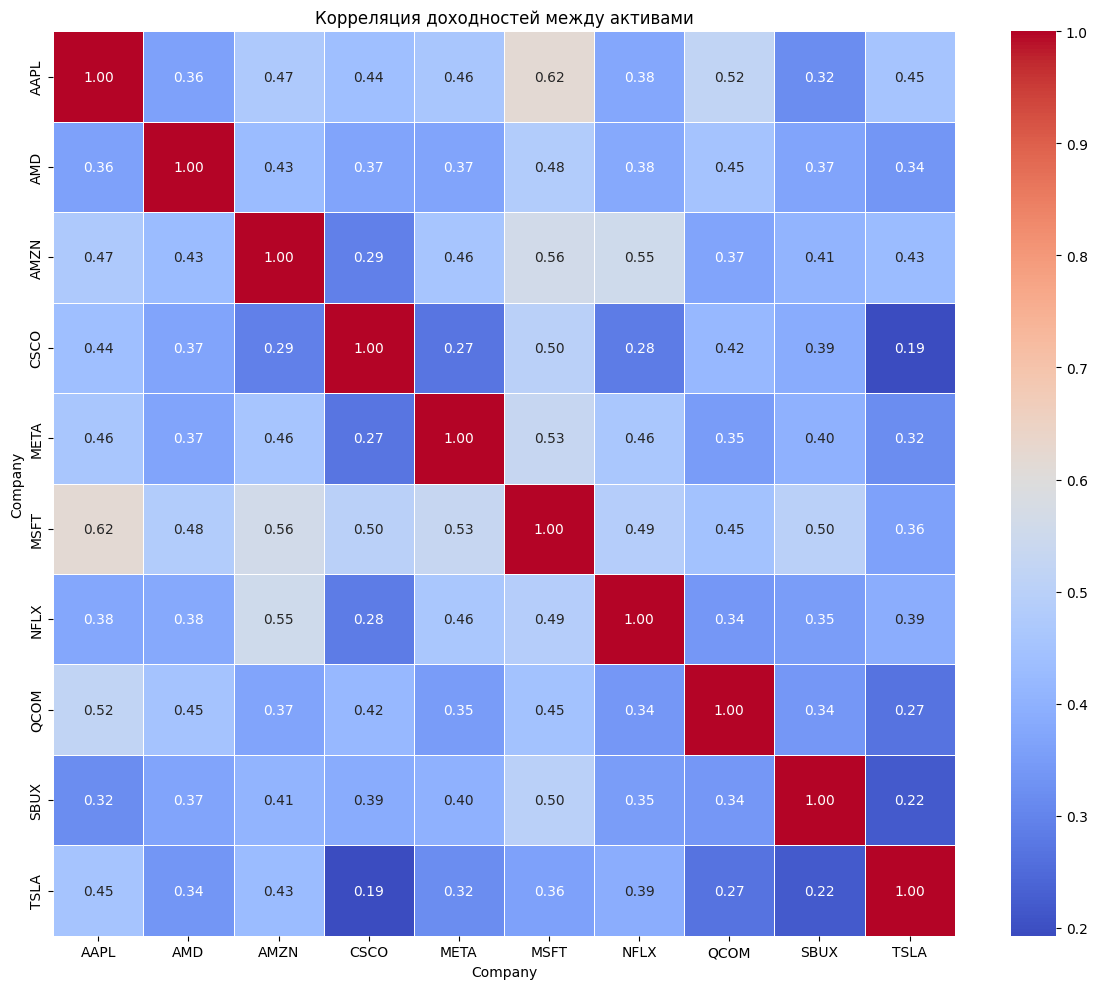

In [200]:
import seaborn as sns
corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляция доходностей между активами")
plt.tight_layout()
plt.show()

# Общие параметры для online-обучения
window_size    - размер скользящего окна
n_init         - размер начального набора данных для предобучения модели
risk_free_rate - доходность безрисковых активов
n_clusters     - колличество кластеров для типов валатильности рынка

In [201]:
window_size = 10 
n_init = 30
risk_free_rate = 0.0002
n_clusters = 3

# Функции обучения пифа

In [202]:
import numpy as np
from scipy.stats import norm

def project_simplex(v):
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0)
    

def solve_pif(R_window, r, lr=0.1, iters=200):
    mu = np.mean(R_window, axis=0)
    Sigma = np.cov(R_window.T)
    n = mu.shape[0]

    def f(w):
        A = w @ mu - r
        B = np.sqrt(w @ Sigma @ w)
        return A / B

    def grad_f(w):
        A = w @ mu - r
        S = Sigma @ w
        B = np.sqrt(w @ Sigma @ w)
        return mu / B - A * S / (B ** 3)

    w = np.ones(n) / n
    best_w = w.copy()
    best_val = f(w)

    for _ in range(iters):
        g = grad_f(w)
        w = w + lr * g
        w = project_simplex(w)
        val = f(w)
        if val > best_val:
            best_val = val
            best_w = w.copy()

    #best_p = norm.cdf(best_val)
    return best_w


In [203]:
def random_pif(R_window, r):
    n = R_window.shape[1]  
    w = np.random.rand(n)
    w = w / np.sum(w) 
    return w

In [204]:
def stocks(R_window, r):
    n = R_window.shape[1]
    w = np.ones(n) / n
    return w

## Аналитика стратегий ПИФ'ов

In [205]:
def pif_count(pif_strategy):
    ret_history = [1]
    risk_free_history = [1]
    returns = []

    for iter in range(window_size, len(df)):
        window = np.array([df.iloc[w_i].values for w_i in range(iter - window_size, iter)])
        best_w = pif_strategy(window, risk_free_rate)

        cur_returns = df.iloc[iter].values  
        ret = best_w @ cur_returns          
        returns.append(ret)
        total_ret = ret_history[-1] * (1 + ret)
        ret_history.append(total_ret)

        risk_free_total = risk_free_history[-1] * (1 + risk_free_rate)
        risk_free_history.append(risk_free_total)
    
    return ret_history, risk_free_history, returns

In [206]:
def pif_analyze(ret_hist, risk_free_hist, rets, title="ПИФ"):
    plt.figure(figsize=(15, 10))
    plt.plot(ret_hist, 'r-', label='доход ПИФ')
    plt.plot(risk_free_hist, 'b-', label='безрисковый доход')
    plt.ylabel('Капитал')
    plt.yscale('log')
    plt.title(f'{title} vs безрисковый доход')
    plt.legend()
    plt.show()

    plt.hist(rets, bins=5)
    plt.title("Распределение доходностей ПИФ")
    plt.show()

    n = len(ret_hist) - 1
    avg_daily_ret = (ret_hist[-1] / ret_hist[0]) ** (1 / n) - 1
    print(f"Средняя дневная доходность: {avg_daily_ret:.6f}")
    print(f"Годовая доходность: {(1 + avg_daily_ret) ** 252 - 1:.2%}")
    print("Средняя дневная доходность по активам:")
    print(df.mean())
    count_positive = 0
    for ret in rets:
        if ret > risk_free_rate:
            count_positive += 1

    print(f"Доля положительных предсказаний: {count_positive / len(rets):.3f}")

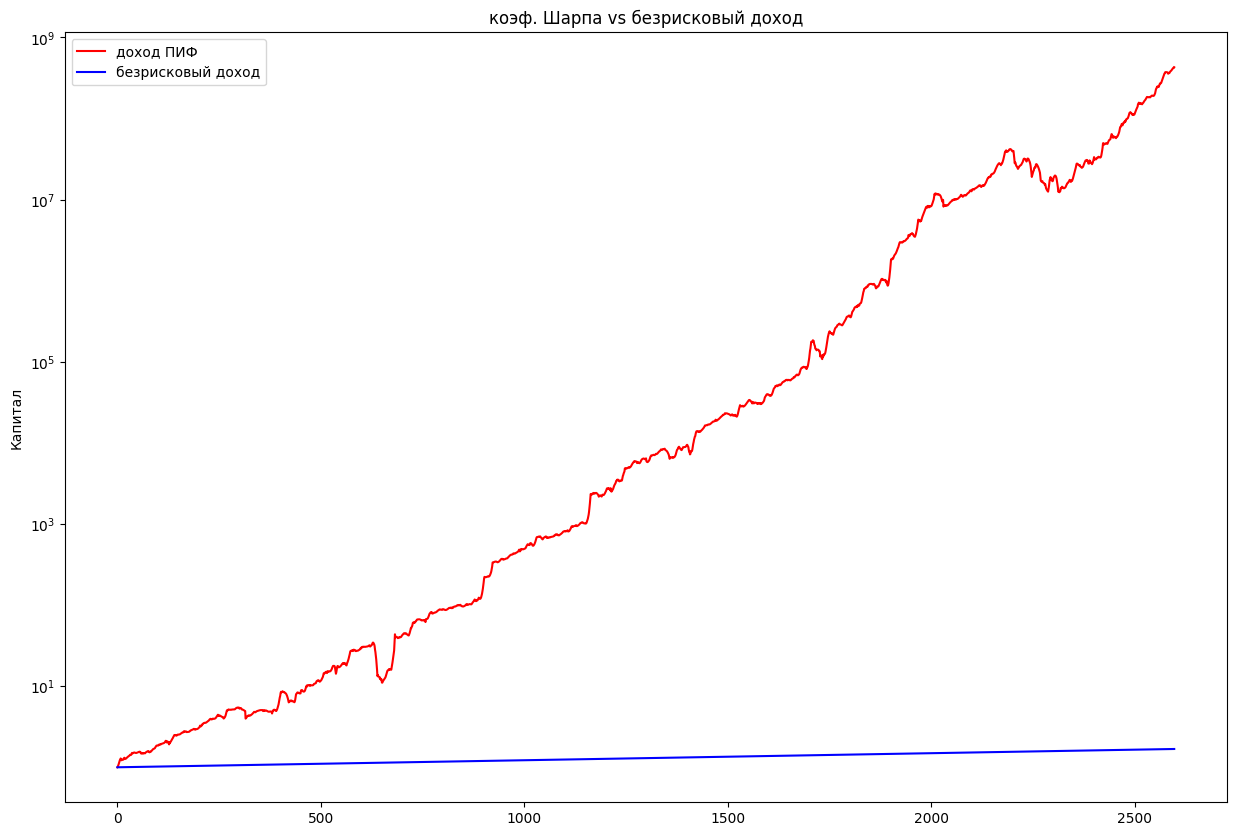

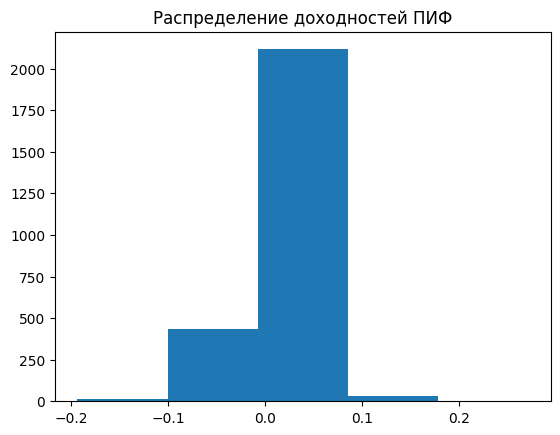

Средняя дневная доходность: 0.007683
Годовая доходность: 588.13%
Средняя дневная доходность по активам:
Company
AAPL    0.003763
AMD     0.004831
AMZN    0.002861
CSCO    0.001044
META    0.003296
MSFT    0.002376
NFLX    0.003277
QCOM    0.001454
SBUX    0.001533
TSLA    0.004896
dtype: float64
Доля положительных предсказаний: 0.665


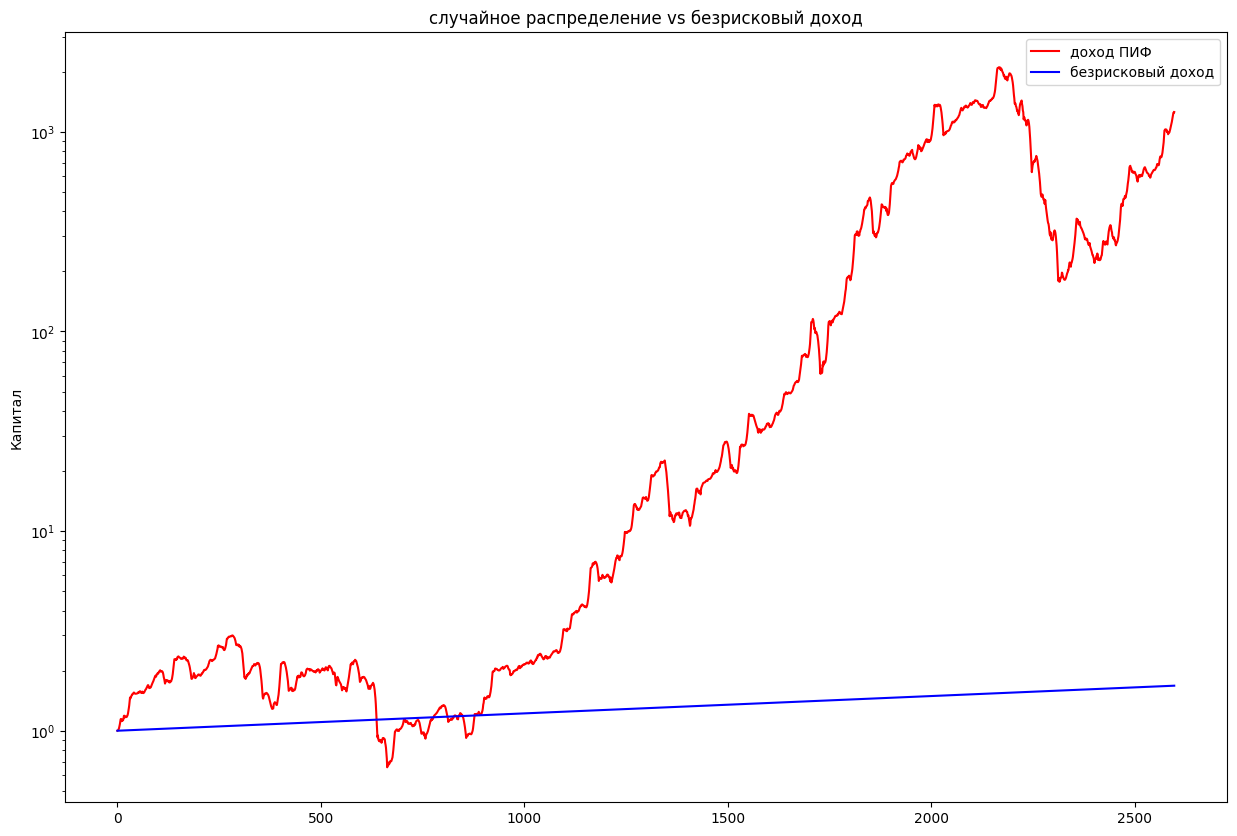

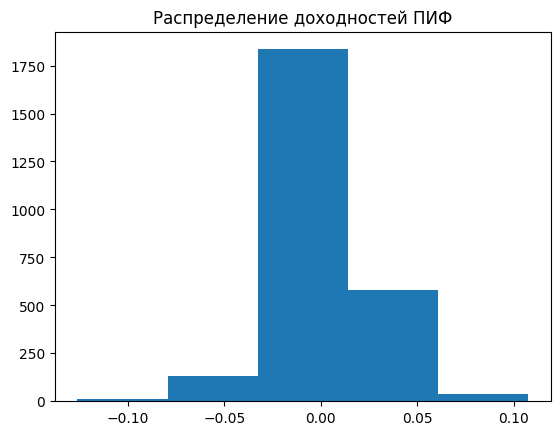

Средняя дневная доходность: 0.002751
Годовая доходность: 99.84%
Средняя дневная доходность по активам:
Company
AAPL    0.003763
AMD     0.004831
AMZN    0.002861
CSCO    0.001044
META    0.003296
MSFT    0.002376
NFLX    0.003277
QCOM    0.001454
SBUX    0.001533
TSLA    0.004896
dtype: float64
Доля положительных предсказаний: 0.588


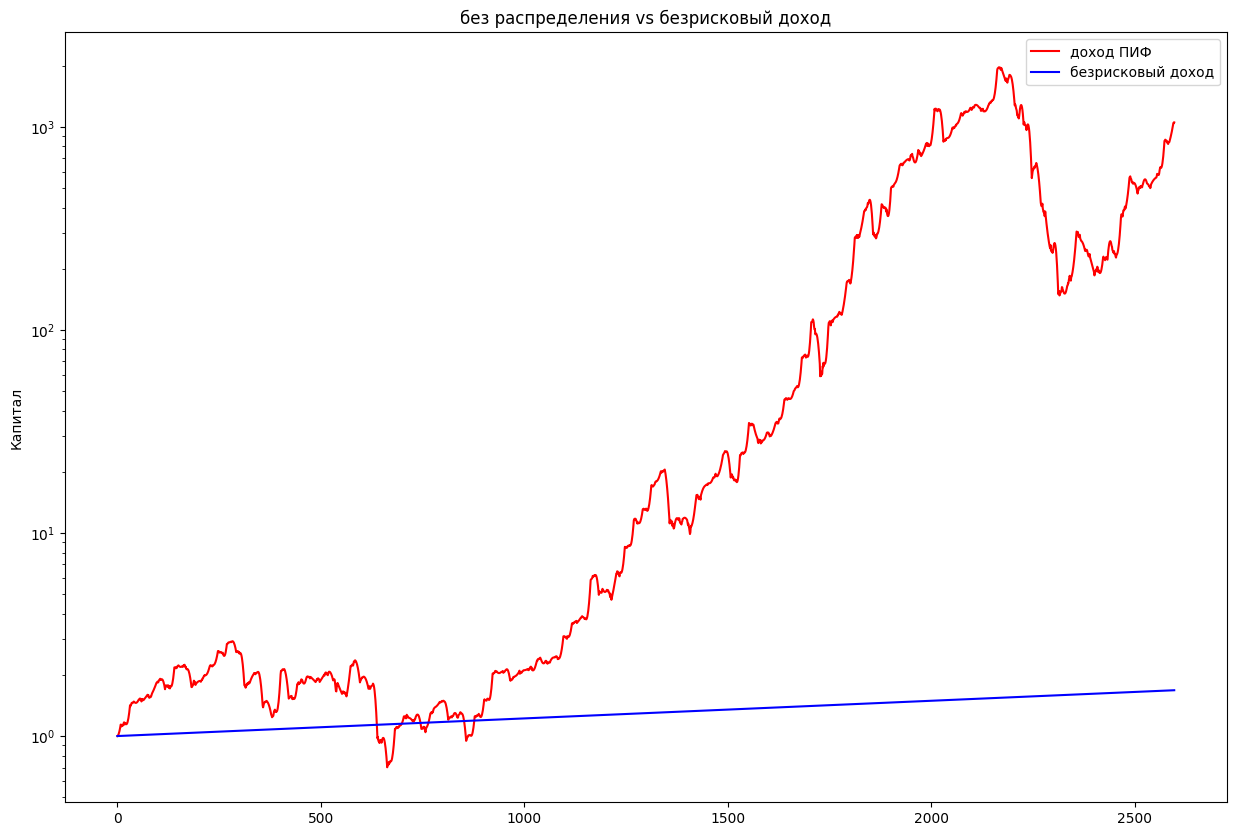

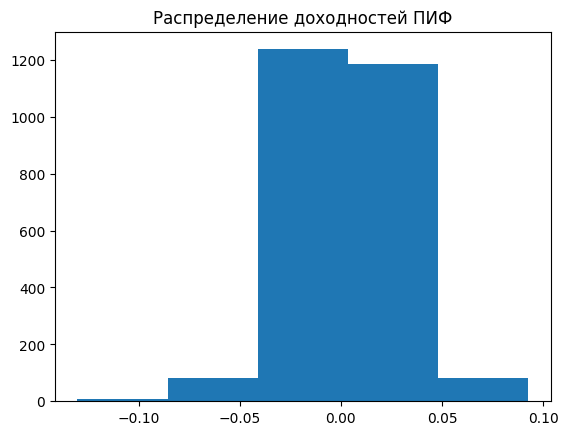

Средняя дневная доходность: 0.002682
Годовая доходность: 96.41%
Средняя дневная доходность по активам:
Company
AAPL    0.003763
AMD     0.004831
AMZN    0.002861
CSCO    0.001044
META    0.003296
MSFT    0.002376
NFLX    0.003277
QCOM    0.001454
SBUX    0.001533
TSLA    0.004896
dtype: float64
Доля положительных предсказаний: 0.589


In [207]:
ret_hist, risk_free_hist, rets = pif_count(solve_pif)
pif_analyze(ret_hist, risk_free_hist, rets, 'коэф. Шарпа')

ret_hist, risk_free_hist, rets = pif_count(random_pif)
pif_analyze(ret_hist, risk_free_hist, rets, 'случайное распределение')

ret_hist, risk_free_hist, rets = pif_count(stocks)
pif_analyze(ret_hist, risk_free_hist, rets, 'без распределения')

## Выводы о работе ПИФ
ПИФ показывает дневную доходность выше средней доходности каждого отдельного актива, что говорит об успешнов распределении активов. 
Годовая доходность в 600% выглядит очень заманчиво, но это без учета комиссии брокера. На деле такой результат гворит о хорошей преспособленности модели к высоковалатильному рынку.

# Онлайн обучение и модели агентов

In [208]:
def make_features(R_window):
    mean = R_window.mean(axis=0)
    std  = R_window.std(axis=0)
    mom  = R_window[-1] - R_window[0]
    return np.hstack([mean, std, mom])

In [209]:
returns = df.values

In [ ]:
all_feats = []
for t in range(window_size, len(returns) - window_size):
    R_w = returns[t-window_size:t]
    all_feats.append(make_features(R_w))
all_feats = np.array(all_feats)

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(all_feats)
cluster_labels = kmeans.labels_.reshape(-1, 1)

ohe = OneHotEncoder(sparse_output=False, categories='auto')
cluster_ohe = ohe.fit_transform(cluster_labels)

In [211]:
def pre_train(model, pif_strategy):
    X_init, y_init = [], []
    for i, t in enumerate(range(window_size, window_size + n_init)):
        R_window = returns[t - window_size:t]
        w_pif = pif_strategy(R_window, risk_free_rate)
        y_pif = returns[t] @ w_pif
        stable = int(y_pif >= risk_free_rate)

        feat = make_features(R_window)
        feat = np.hstack([feat, cluster_ohe[i]])
        X_init.append(feat)
        y_init.append(stable)
    model.fit(X_init, y_init)

In [212]:
def online_train(model, pif_strategy):
    regrets, portfolio_returns, agent_returns, stability_checks = [], [], [], []
    cum_reg = 0

    for idx, t in enumerate(range(window_size + n_init, len(returns) - window_size - 1)):
        R_window = returns[t-window_size:t]
        w_pif = pif_strategy(R_window, risk_free_rate)
        y_pif = returns[t] @ w_pif


        portfolio_returns.append(y_pif)
        stable = int(y_pif >= risk_free_rate)

        feat = make_features(R_window)
        cluster_idx = t - window_size
        X_agent = np.hstack([feat, cluster_ohe[cluster_idx]])
        X_agent = X_agent.reshape(1, -1)

        prob = model.predict_proba(X_agent)[0, 1]
        x_ag = int(prob >= 0.5)
        stability_checks.append(int(stable == x_ag))
        agent_ret = prob * y_pif + (1 - prob) * risk_free_rate
        agent_returns.append(agent_ret)
        U_opt = max(y_pif, risk_free_rate)
        U_agent = prob * y_pif + (1-prob)*risk_free_rate

        step_reg = U_opt - U_agent
        cum_reg += step_reg
        regrets.append(cum_reg)

        model.partial_fit(X_agent, [int(y_pif >= risk_free_rate)], classes=[0,1])

    return regrets, portfolio_returns, agent_returns, stability_checks

In [213]:
def analyze_model(name, regrets, portfolio_returns, agent_returns, stability_checks):
    plt.figure(figsize=(10, 4))
    plt.plot(regrets, label=f"Regret {name}")
    plt.title("Динамика сожаления агента")
    plt.xlabel("Шаг времени")
    plt.ylabel("Regret")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(np.cumsum(stability_checks)/np.arange(1,len(stability_checks)+1), label="Доля соблюдения интересов")
    plt.title(f"Соблюдение интересов {name}")
    plt.xlabel("Шаг времени")
    plt.ylabel("Доля стабильности")
    plt.grid(True)
    plt.legend()
    plt.show()

    cum_portfolio_returns = np.cumprod(1 + np.array(portfolio_returns)) - 1
    cum_agent_returns = np.cumprod(1 + np.array(agent_returns)) - 1

    plt.figure(figsize=(10, 4))
    plt.plot(cum_portfolio_returns, label="ПИФ (портфель)")
    plt.plot(cum_agent_returns, label="Агент (онлайн стратегия)")
    plt.title(f"Сравнение накопленной доходности {name}")
    plt.xlabel("Шаг времени")
    plt.ylabel("Накопленная доходность")
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

In [214]:
class SGDPipe:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = SGDClassifier(
        loss='log_loss',
        penalty='l2',
        alpha=1e-4,
        learning_rate='invscaling',
        eta0=0.01,
        power_t=0.25,
        average=True,
        max_iter=10,
        warm_start=True,
        random_state=0
        )
    
    def partial_fit(self, x, y, classes):
        x_scaled = self.scaler.transform(x)
        self.model.partial_fit(x_scaled, y, classes)

    def fit(self, x, y):
        x_scaled = self.scaler.fit_transform(x)
        self.model.fit(x_scaled, y)
    
    def predict_proba(self, x):
        x_scaled = self.scaler.transform(x)
        return self.model.predict_proba(x)

In [215]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

class LogisticPipe:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = LogisticRegression(
            solver='saga',
            warm_start=True,
            max_iter=10,
            random_state=0
        )
        self.x_buffer = []
        self.y_buffer = []

    def fit(self, x, y):
        x_scaled = self.scaler.fit_transform(x)
        self.model.fit(x_scaled, y)

    def partial_fit(self, x, y, classes):
        x = x.reshape(1, -1)
        self.x_buffer.append(x)
        self.y_buffer.append(y[0])
        
        if len(set(self.y_buffer)) < 2:
            return  
        
        x_batch = np.vstack(self.x_buffer)
        y_batch = np.array(self.y_buffer)

        x_scaled = self.scaler.transform(x_batch)
        self.model.fit(x_scaled, y_batch)
        
        self.x_buffer.clear()
        self.y_buffer.clear()

    def predict_proba(self, x):
        x_scaled = self.scaler.transform(x)
        return self.model.predict_proba(x_scaled)

In [216]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

class NBPipe:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = GaussianNB()

    def fit(self, x, y):
        x_scaled = self.scaler.fit_transform(x)
        self.model.fit(x_scaled, y)

    def partial_fit(self, x, y, classes):
        x_scaled = self.scaler.transform(x)
        self.model.partial_fit(x_scaled, y, classes)

    def predict_proba(self, x):
        x_scaled = self.scaler.transform(x)
        return self.model.predict_proba(x_scaled)


In [217]:
from sklearn.neural_network import MLPClassifier

class MLPPipe:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = MLPClassifier(
            hidden_layer_sizes=(32, 16),
            solver='adam',
            max_iter=10,
            warm_start=True,
            random_state=0
        )
        self.initialized = False
        self.x_buffer = []
        self.y_buffer = []

    def fit(self, x, y):
        x_scaled = self.scaler.fit_transform(x)
        self.model.fit(x_scaled, y)
        self.initialized = True

    def partial_fit(self, x, y, classes):
        x = x.reshape(1, -1) 
        self.x_buffer.append(x)
        self.y_buffer.append(y[0]) 

        if len(set(self.y_buffer)) < 2:
            return  
        
        x_batch = np.vstack(self.x_buffer)
        y_batch = np.array(self.y_buffer)
        
        if not self.initialized:
            x_scaled = self.scaler.fit_transform(x_batch)
            self.model.partial_fit(x_scaled, y_batch, classes=classes)
            self.initialized = True
        else:
            x_scaled = self.scaler.transform(x_batch)
            self.model.partial_fit(x_scaled, y_batch)


        self.x_buffer.clear()
        self.y_buffer.clear()

    def predict_proba(self, x):
        x_scaled = self.scaler.transform(x)
        return self.model.predict_proba(x_scaled)

In [218]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler
from scipy.special import expit 

class PassiveAggressivePipe:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = PassiveAggressiveClassifier(
            max_iter=10,
            warm_start=True,
            random_state=0
        )

    def fit(self, x, y):
        x_scaled = self.scaler.fit_transform(x)
        self.model.fit(x_scaled, y)

    def partial_fit(self, x, y, classes):
        x_scaled = self.scaler.transform(x)
        self.model.partial_fit(x_scaled, y, classes)

    def predict_proba(self, x):
        x_scaled = self.scaler.transform(x)
        decision = self.model.decision_function(x_scaled)
        proba = expit(decision) 
        return np.column_stack([1 - proba, proba])

In [219]:
sgd_plain = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=1e-4,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    average=True,
    max_iter=10,
    warm_start=True,
    random_state=0
)
sgd_pipe = SGDPipe()
log_reg = LogisticPipe()
gaussian = NBPipe()
mlp = MLPPipe()
passive_aggressive = PassiveAggressivePipe()

In [220]:
model_map = {
    "SGD plain" : SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=1e-4,
    learning_rate='invscaling',
    eta0=0.01,
    power_t=0.25,
    average=True,
    max_iter=1,
    warm_start=True,
    random_state=0
    ),
    "SGD scaler" : SGDPipe(),
    "LogRegression" : LogisticPipe(),
    "Gaussian" : NBPipe(),
    "MLP" : MLPPipe(),
    "PassiveAggressive" : PassiveAggressivePipe()
}

## Анализ работы моделей агента

testing SGD plain


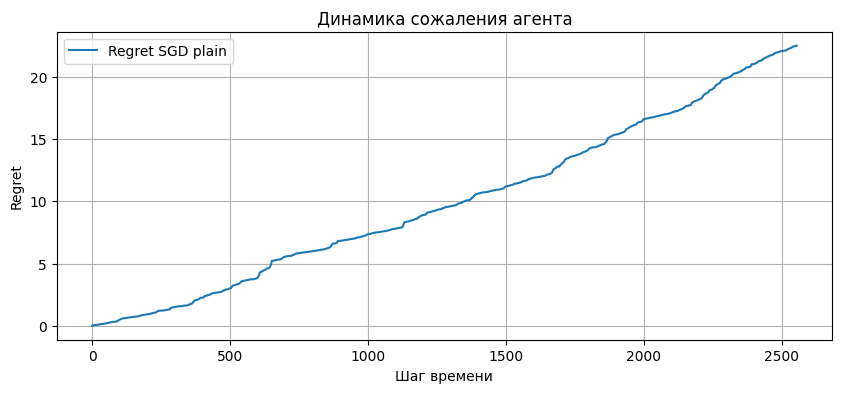

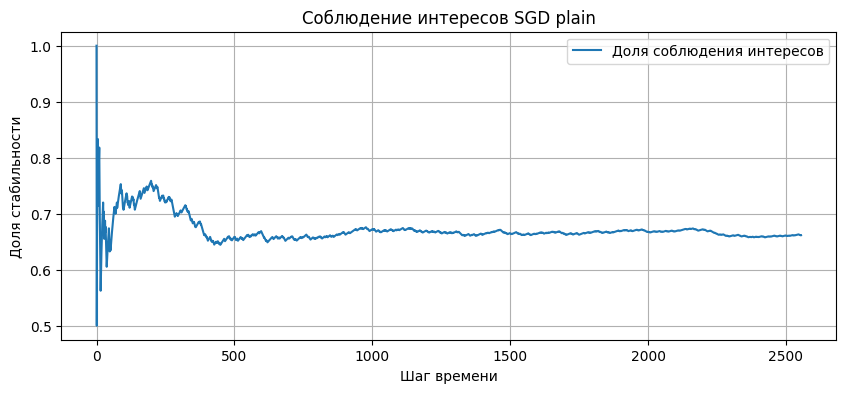

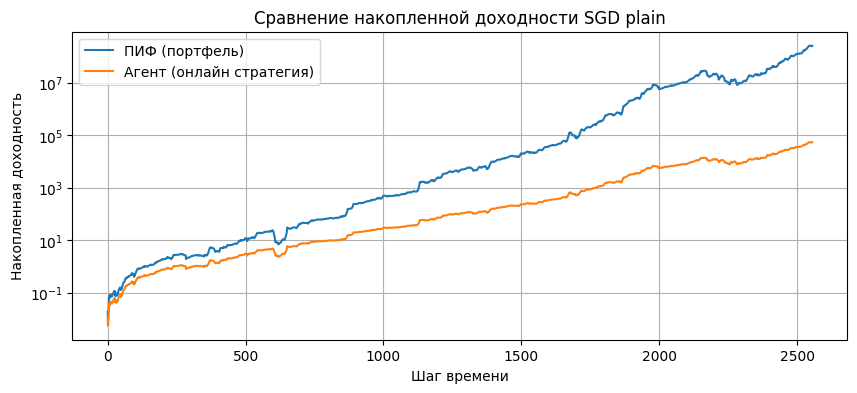

testing SGD scaler


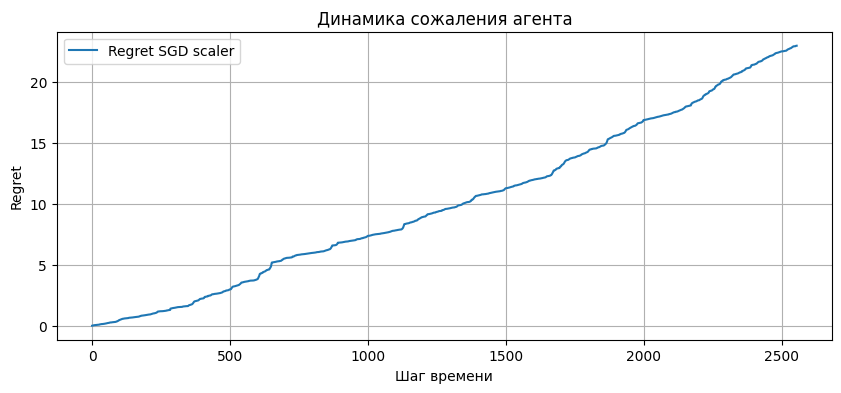

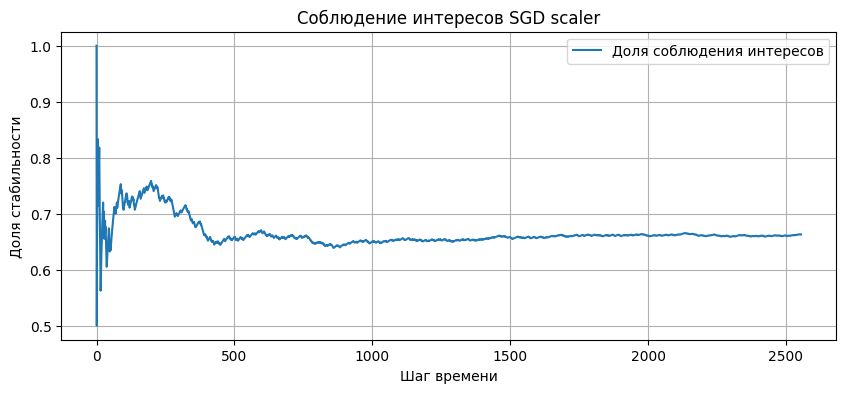

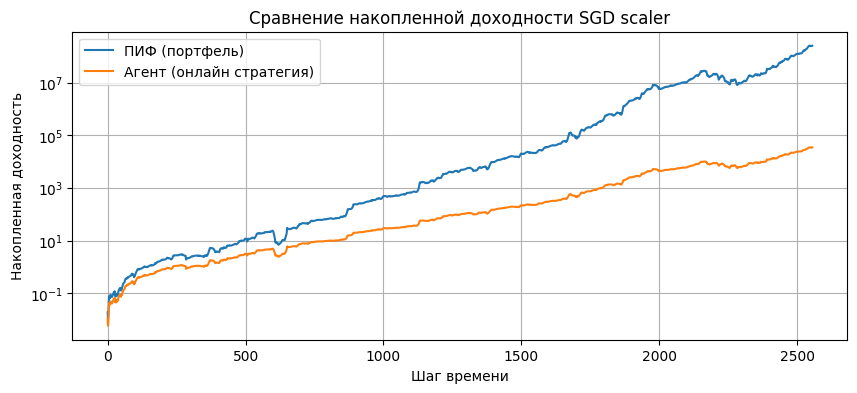

testing LogRegression


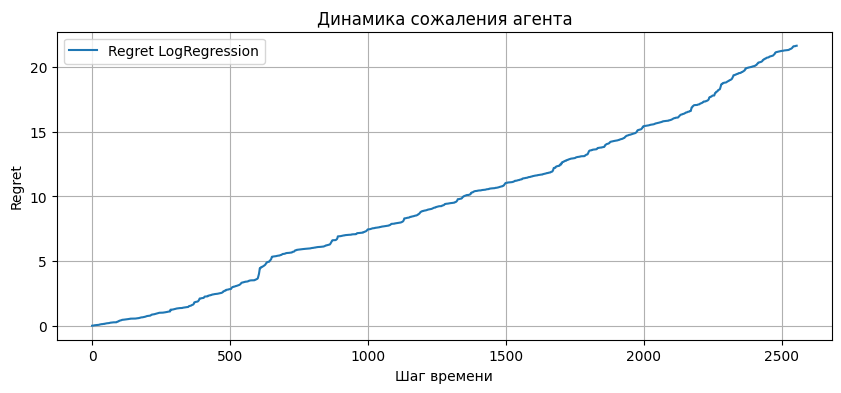

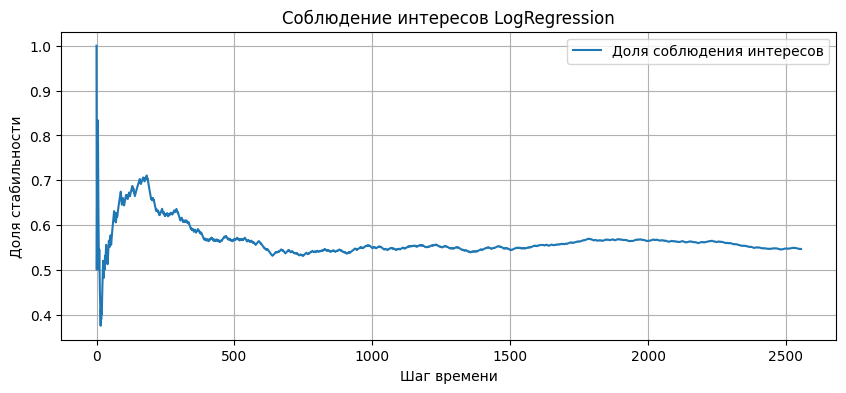

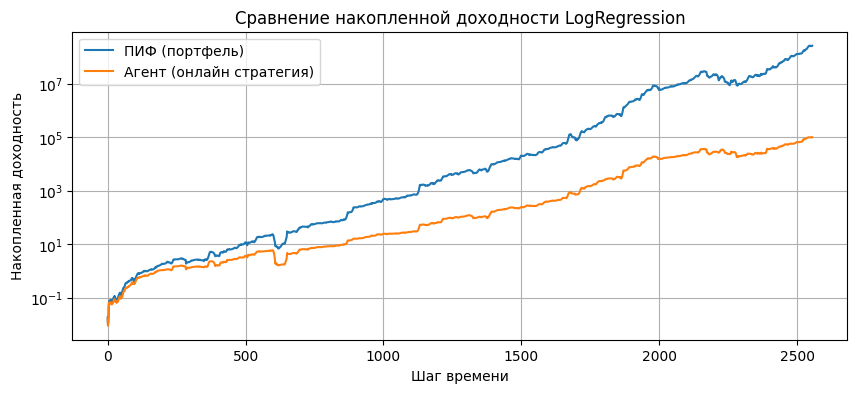

testing Gaussian


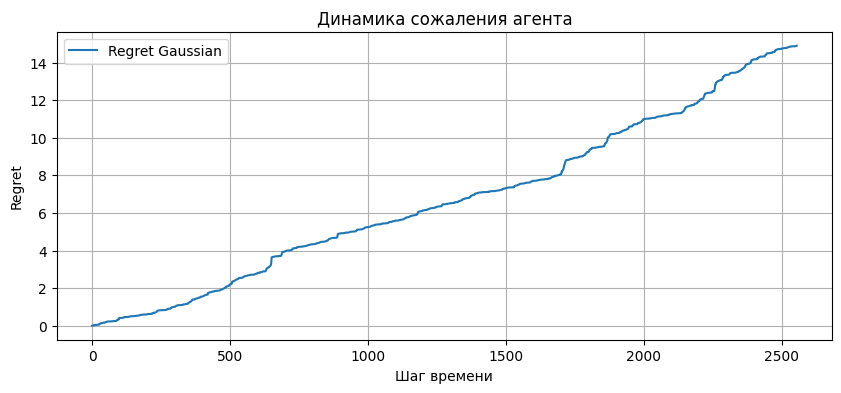

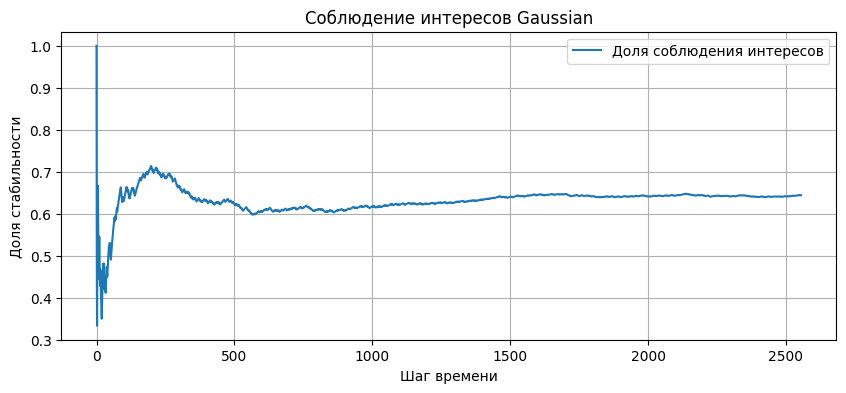

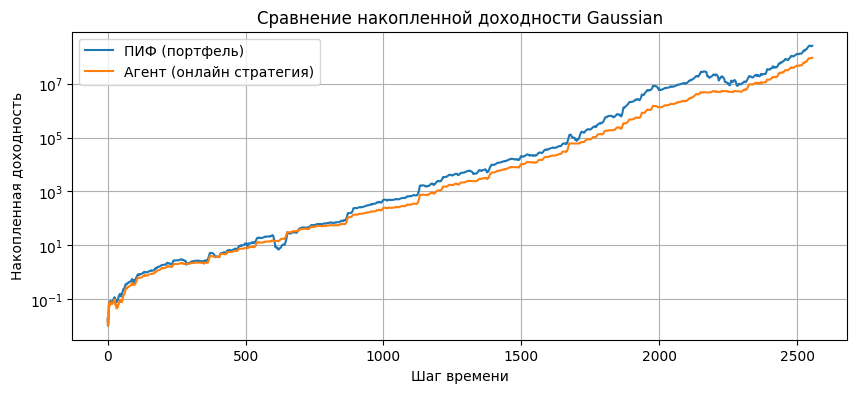

testing MLP


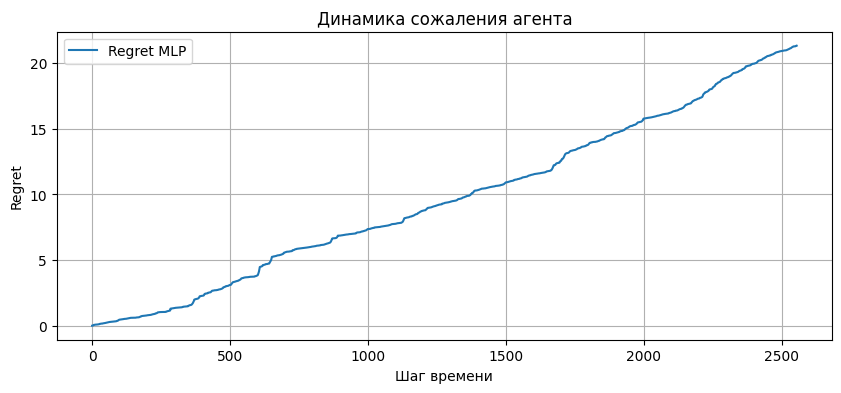

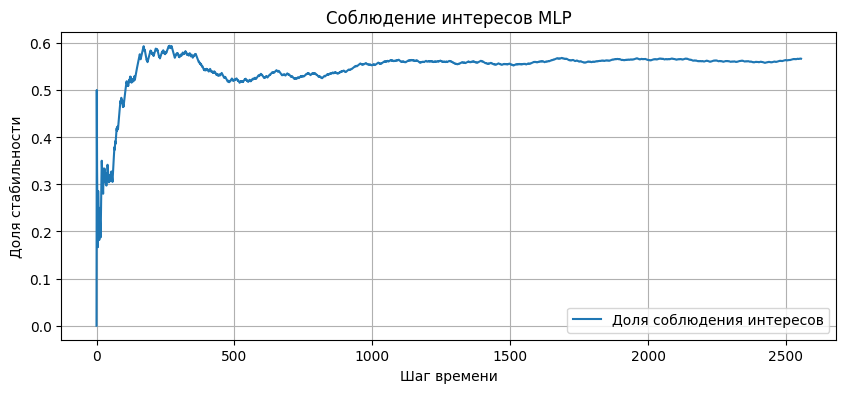

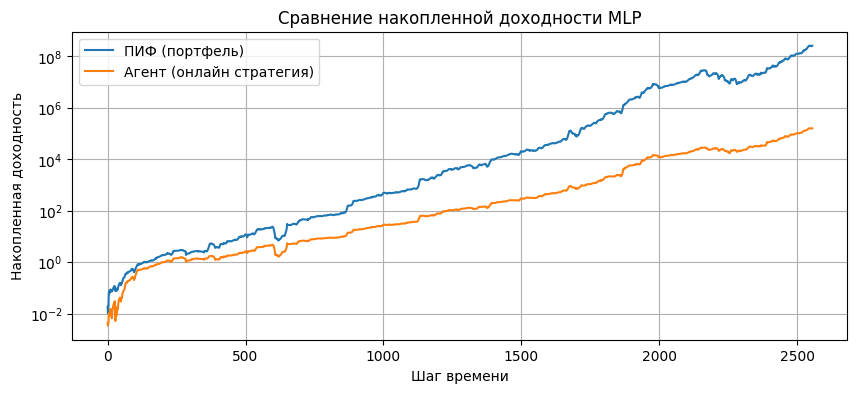

testing PassiveAggressive


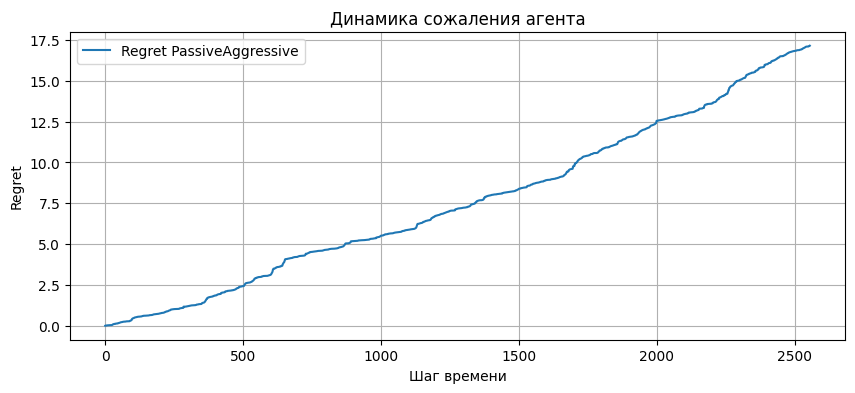

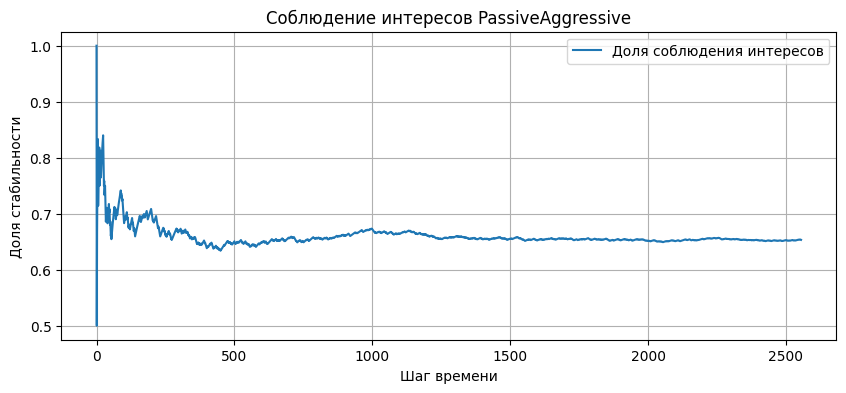

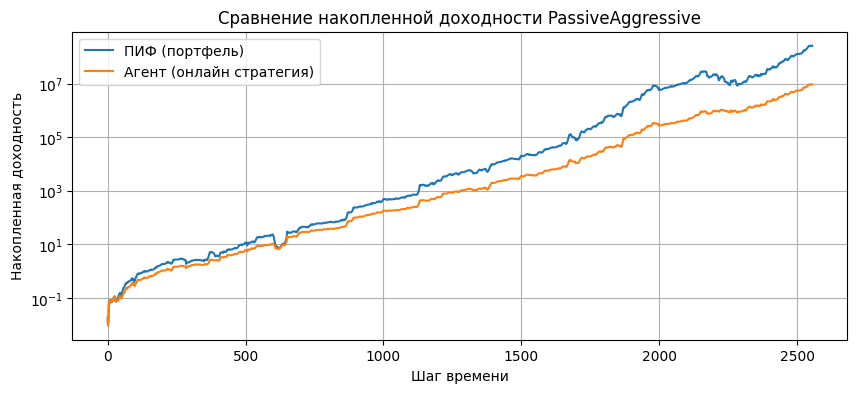

In [221]:
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

for name, model in model_map.items():
    print(f'testing {name}')
    pre_train(model, solve_pif)
    regrets, portfolio_returns, agent_returns, stability_checks = online_train(model, solve_pif)
    analyze_model(name, regrets, portfolio_returns, agent_returns, stability_checks)

## Анализ лучших моделей агента с разными стратегиями ПИФ'а

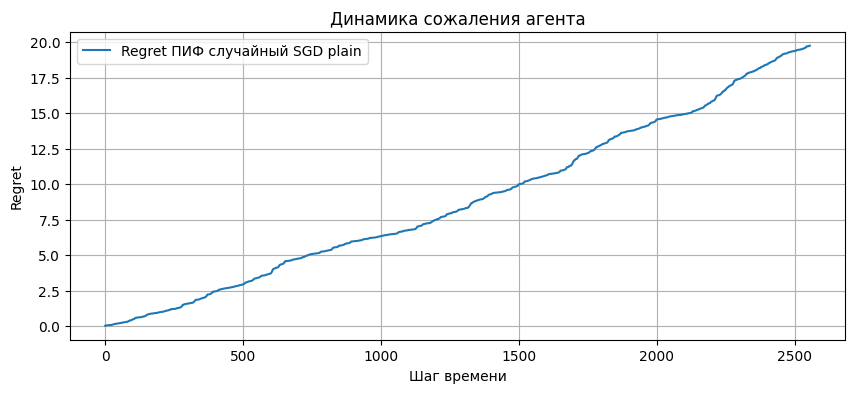

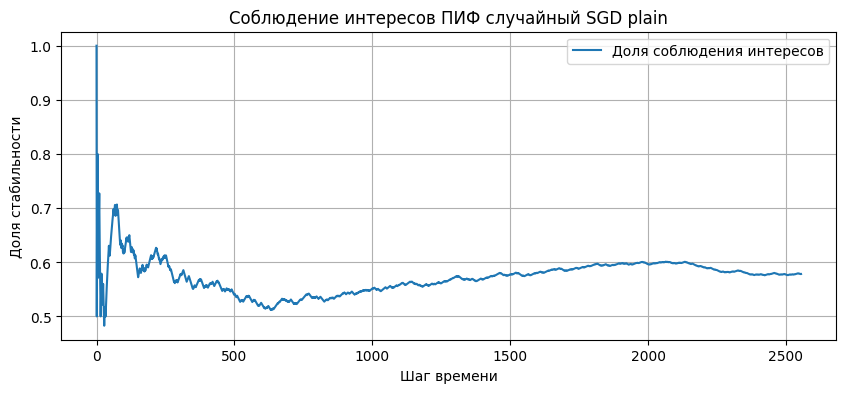

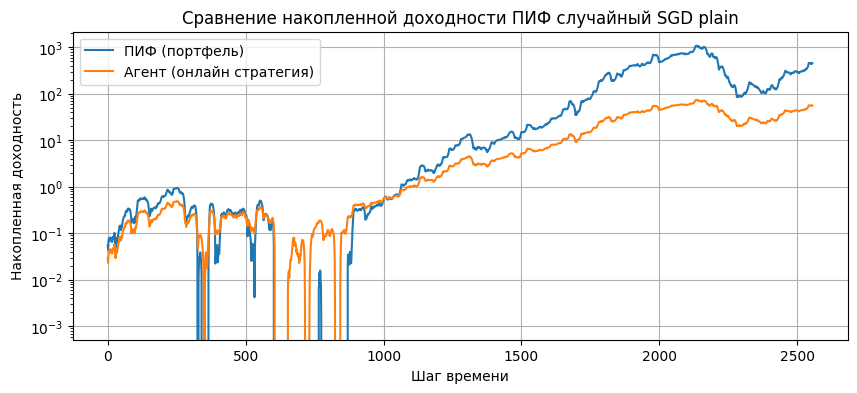

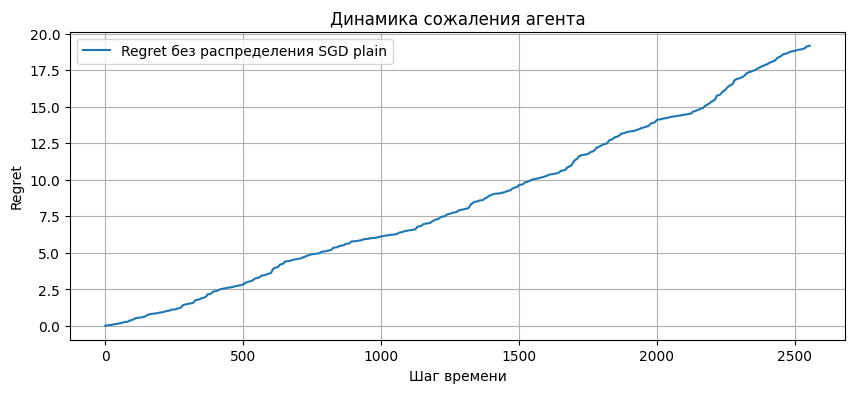

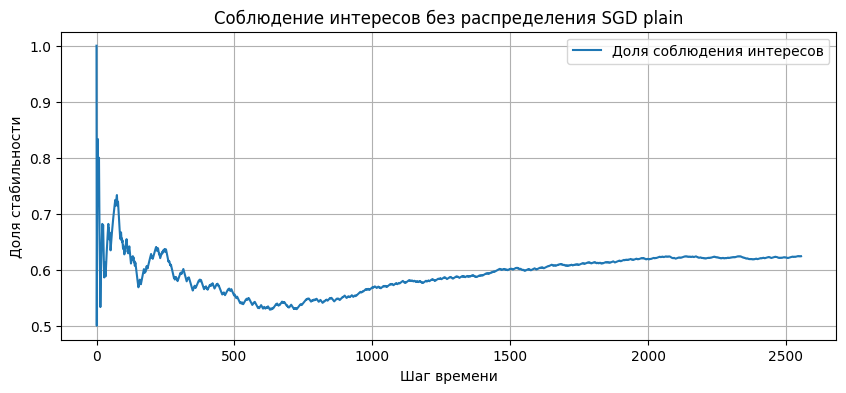

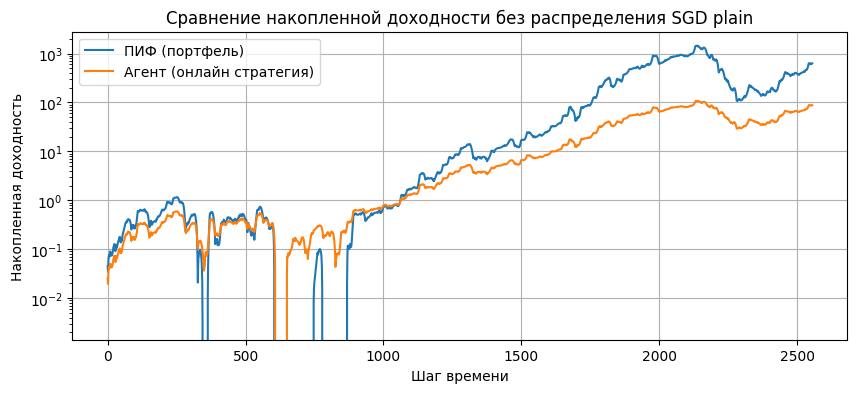

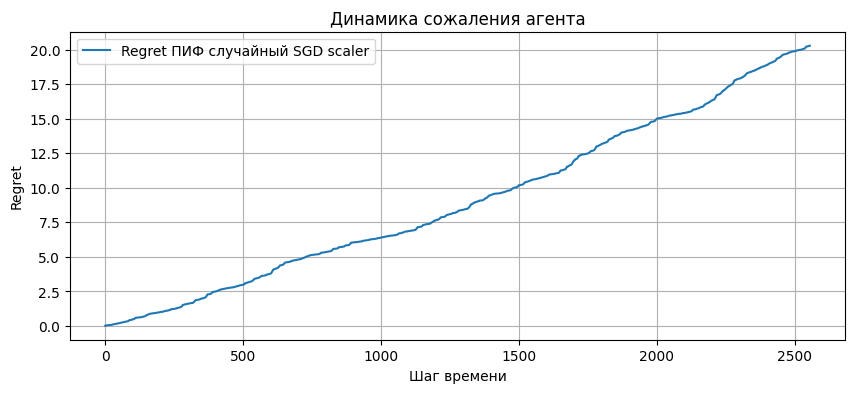

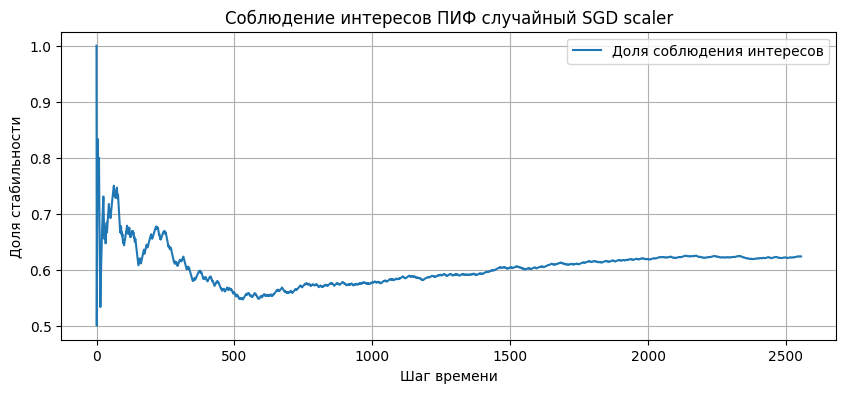

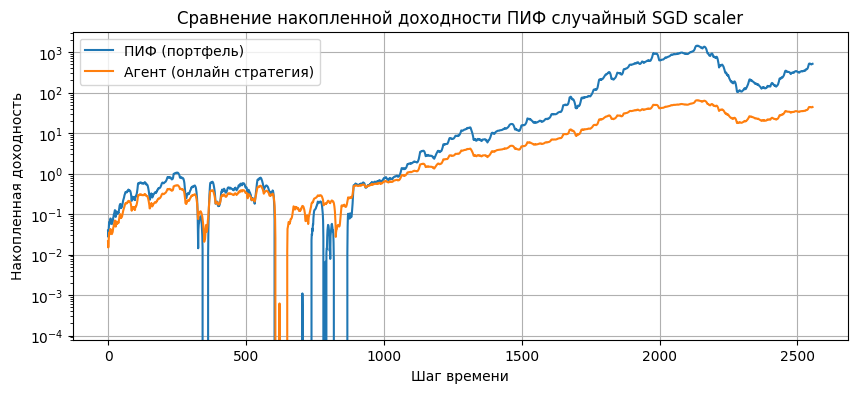

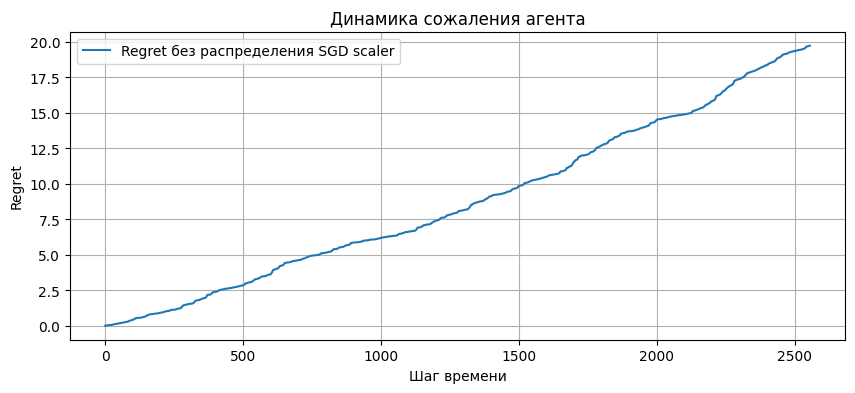

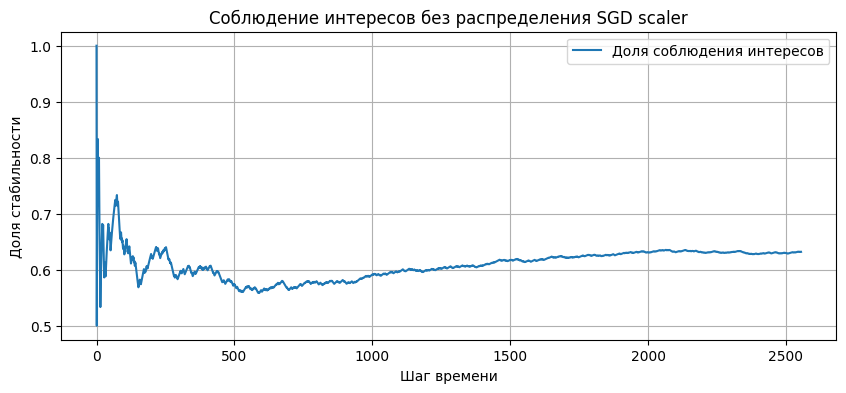

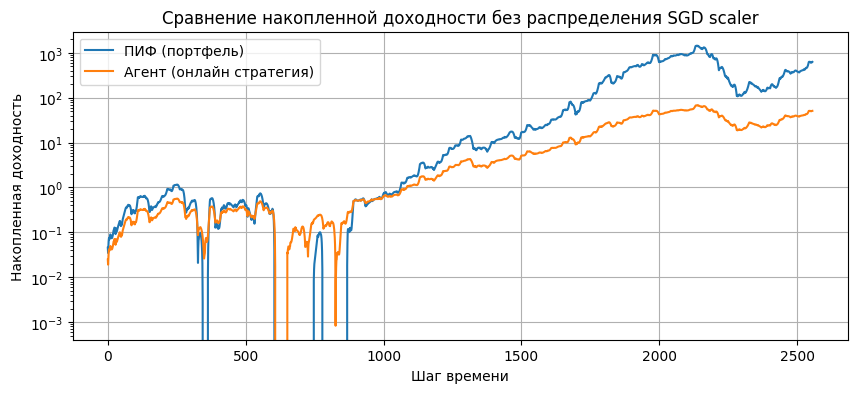

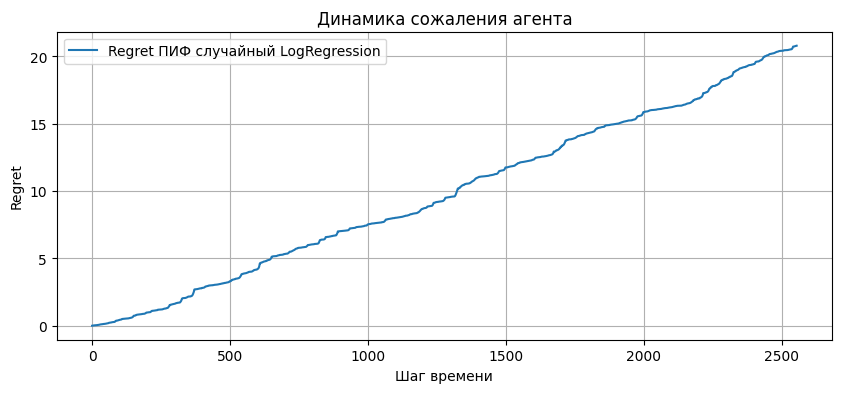

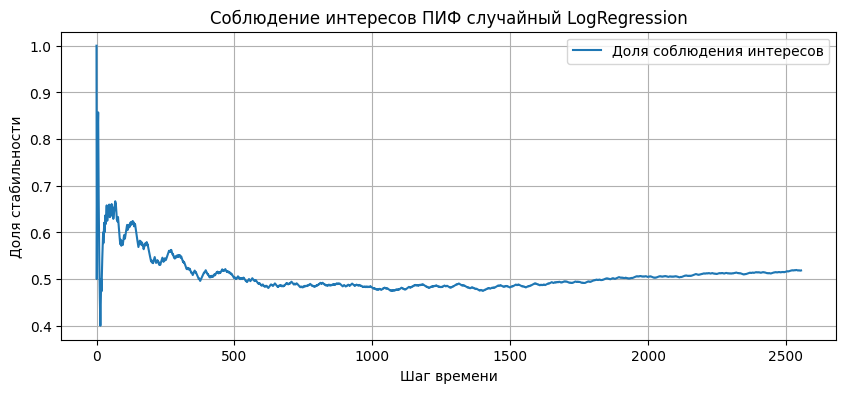

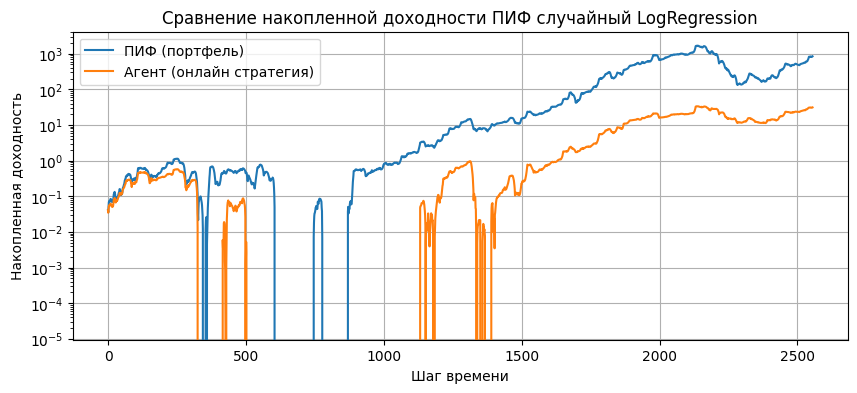

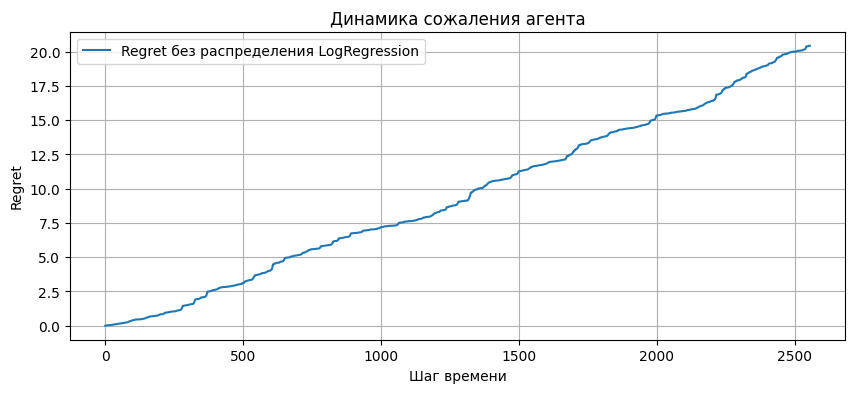

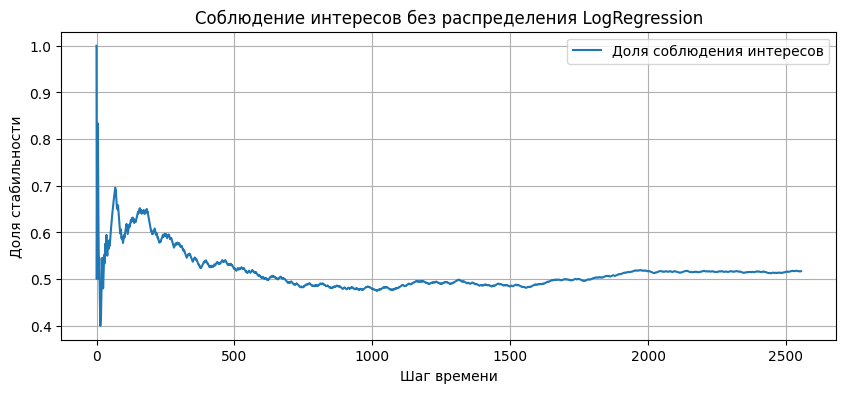

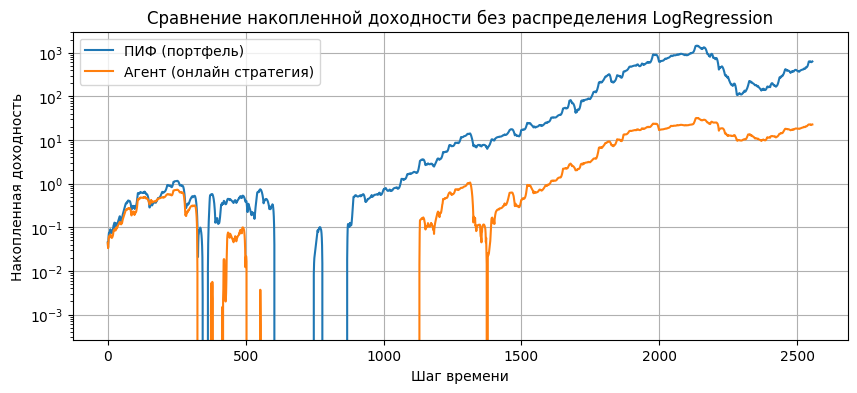

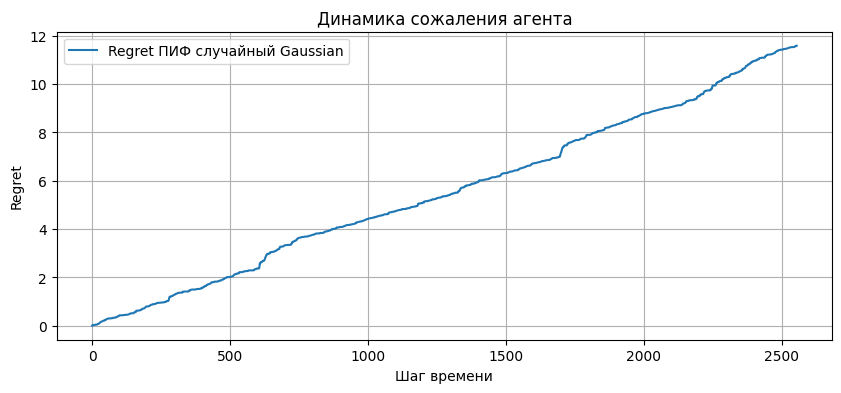

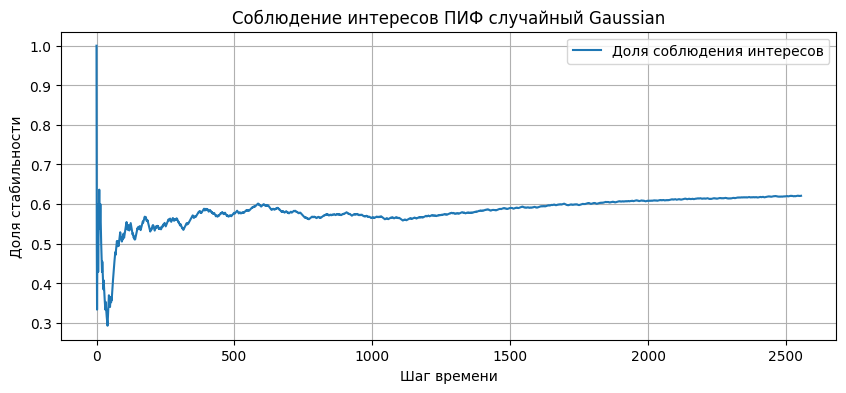

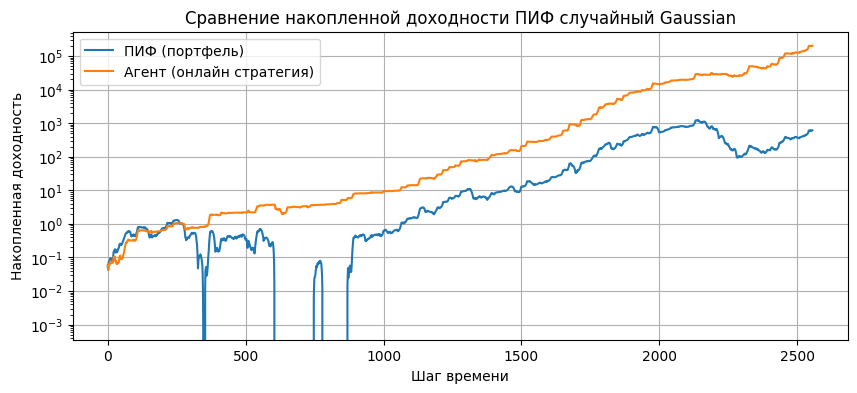

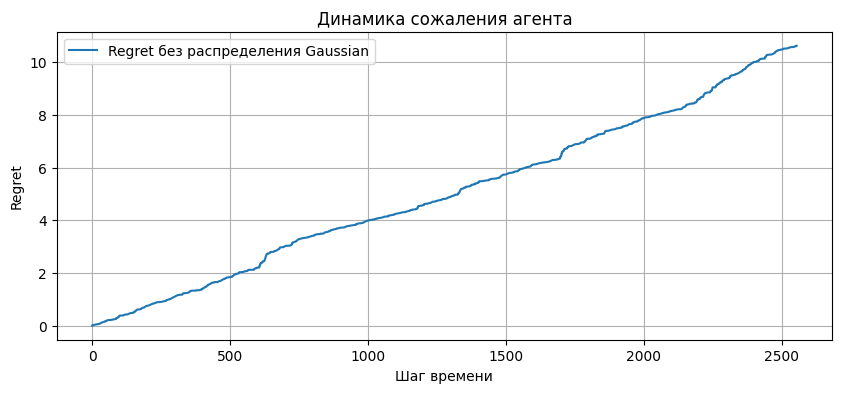

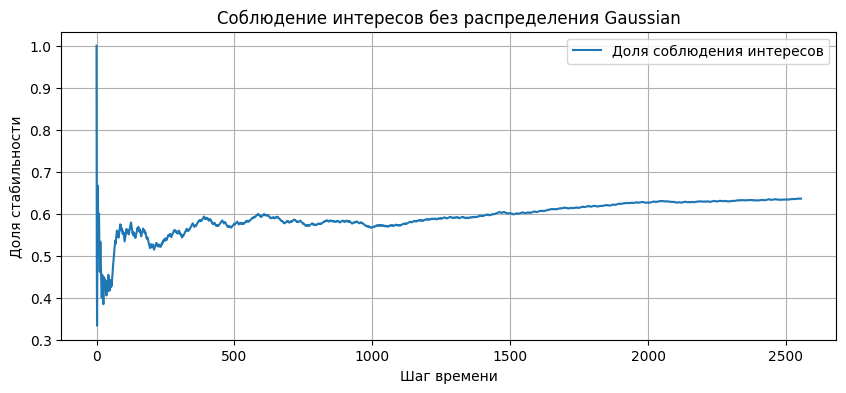

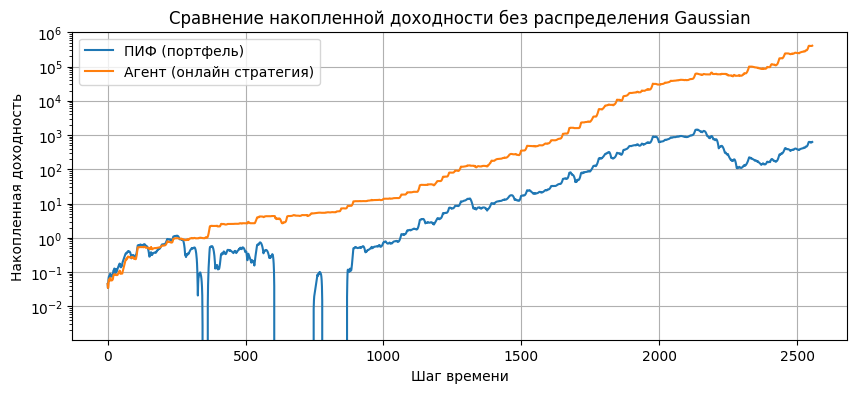

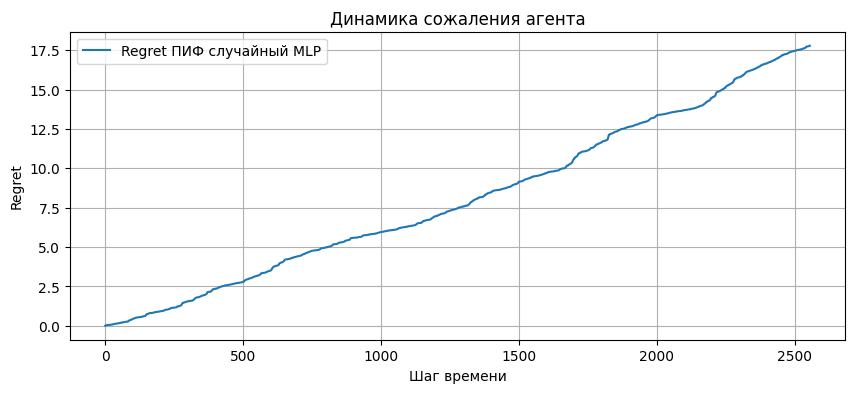

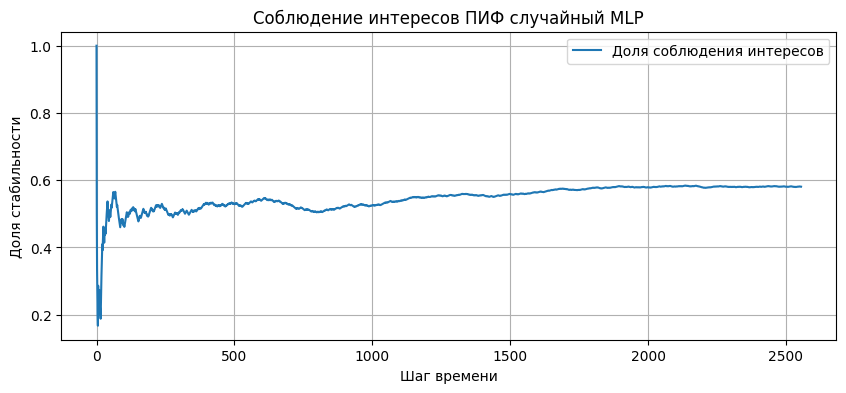

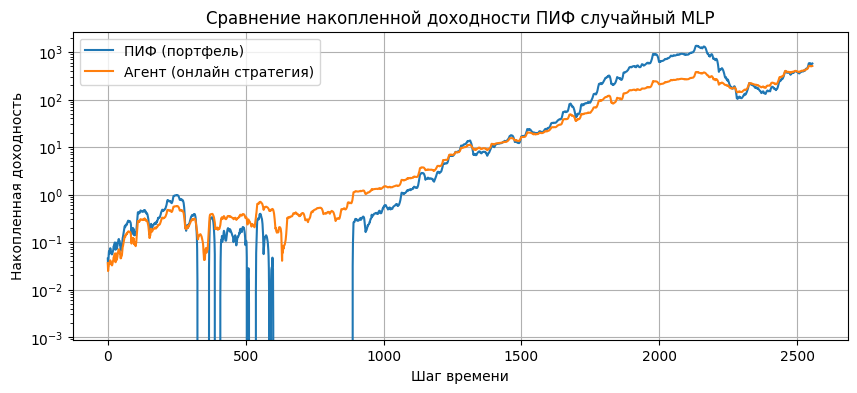

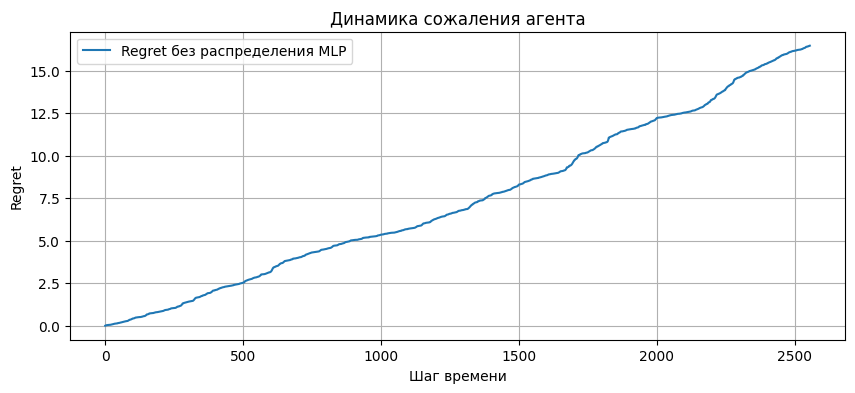

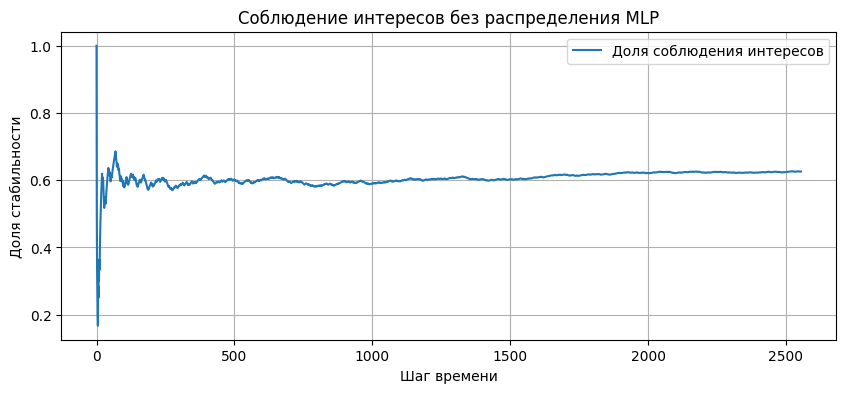

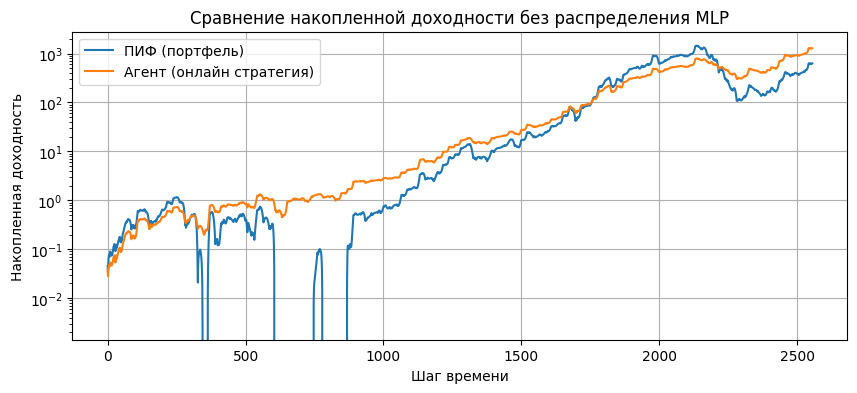

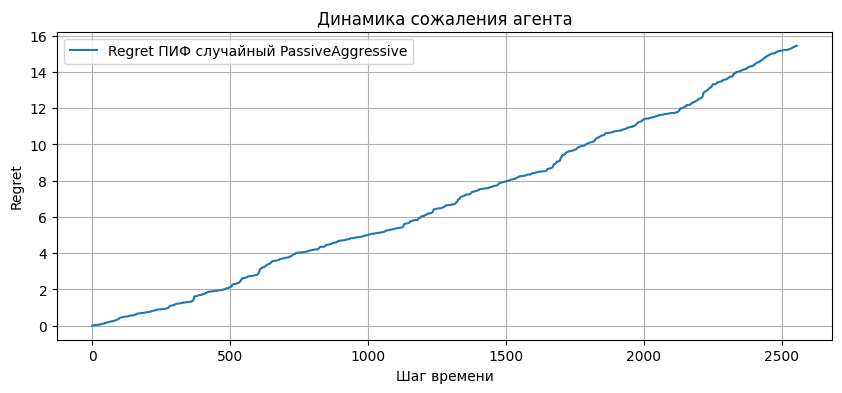

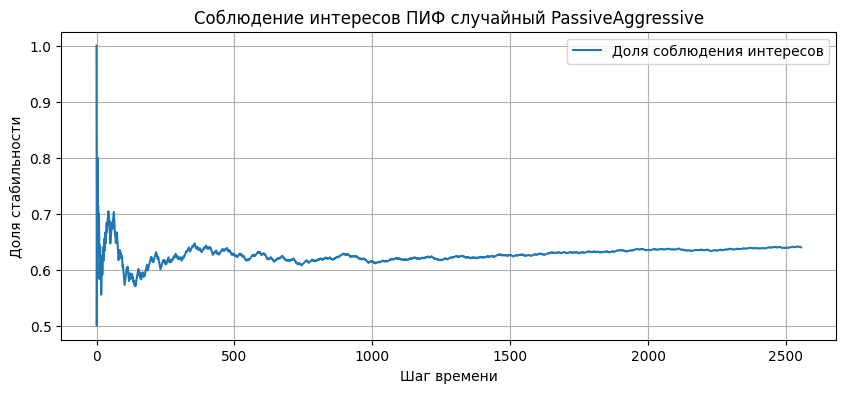

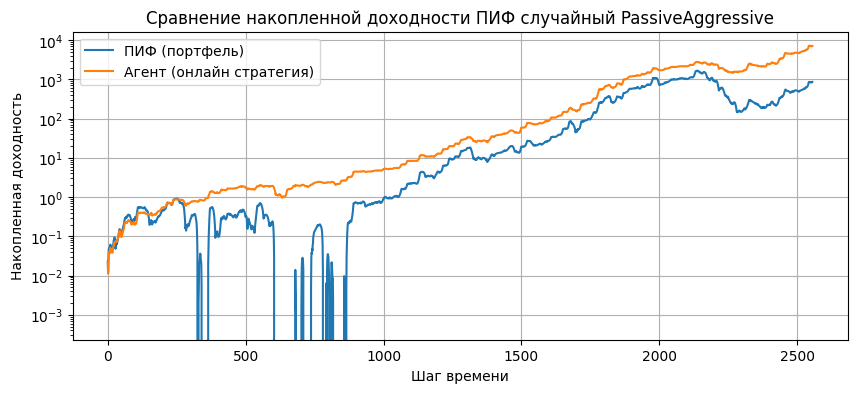

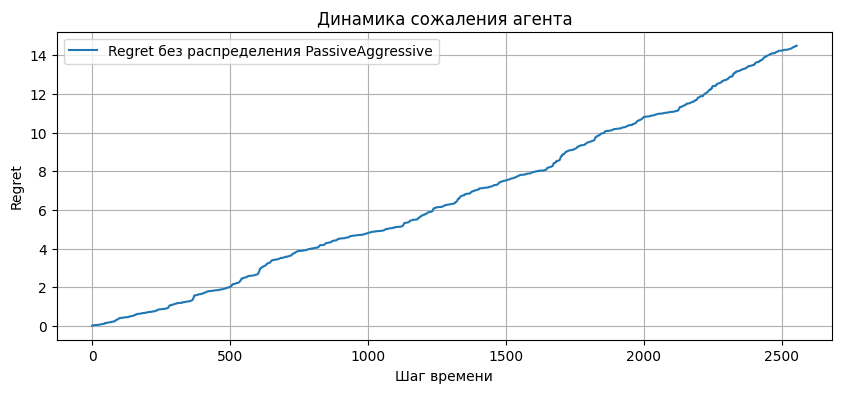

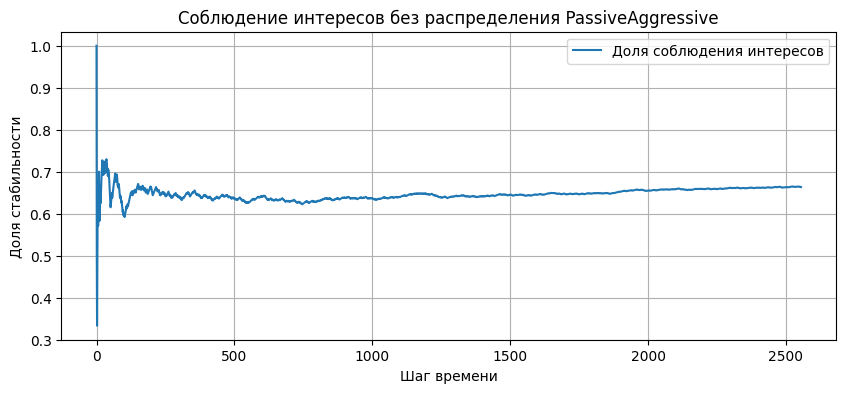

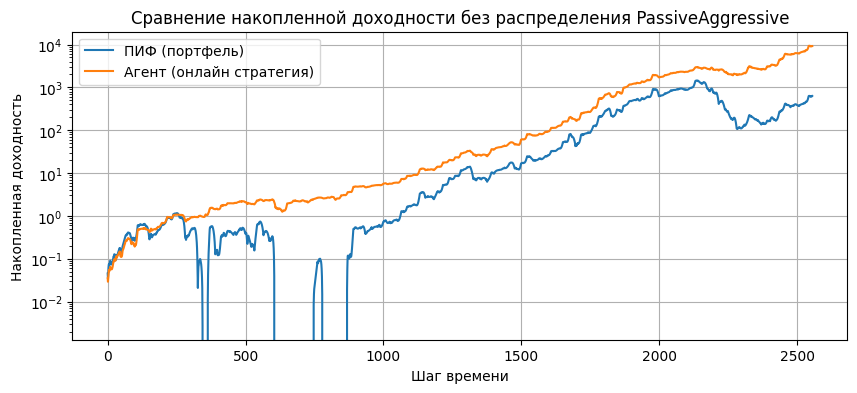

In [222]:
for name, model in model_map.items():
    pre_train(model, random_pif)
    regrets, portfolio_returns, agent_returns, stability_checks = online_train(model, random_pif)
    analyze_model(f'ПИФ случайный {name}', regrets, portfolio_returns, agent_returns, stability_checks)
    
    pre_train(model, stocks)
    regrets, portfolio_returns, agent_returns, stability_checks = online_train(model, stocks)
    analyze_model(f'без распределения {name}', regrets, portfolio_returns, agent_returns, stability_checks)